In [2]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

COLORS = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7", "#DDA0DD"]

print("Setup complete!")

Setup complete!


In [3]:
# Generate sample data for notebook
np.random.seed(42)

# Generate transactions
transaction_data = []
start_date = datetime(2025, 1, 1)
for i in range(10000):
    timestamp = start_date + timedelta(
        days=np.random.randint(0, 365),
        hours=np.random.randint(10, 22)
    )
    transaction_data.append({
        'transaction_id': i + 1,
        'customer_id': np.random.randint(1, 501),
        'item_id': np.random.randint(1, 51),
        'quantity': np.random.randint(1, 4),
        'total_price': round(np.random.uniform(10, 80), 2),
        'timestamp': timestamp,
    })
transactions = pd.DataFrame(transaction_data)
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

# Generate customers
customer_data = []
for i in range(500):
    customer_data.append({
        'customer_id': i + 1,
        'first_name': f'Customer_{i+1}',
        'join_date': datetime(2024, 1, 1) + timedelta(days=np.random.randint(0, 365)),
    })
customers = pd.DataFrame(customer_data)

print(f"Transactions: {len(transactions):,} records")
print(f"Customers: {len(customers):,} customers")

Transactions: 10,000 records
Customers: 500 customers


## 1. RFM Segmentation

RFM (Recency, Frequency, Monetary) analysis segments customers based on:

- **Recency**: How recently they made a purchase
- **Frequency**: How often they purchase
- **Monetary**: How much they spend


In [4]:
# RFM Analysis (inline implementation)
analysis_date = transactions['timestamp'].max() + timedelta(days=1)

# Calculate RFM metrics
rfm_df = transactions.groupby('customer_id').agg({
    'timestamp': lambda x: (analysis_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'total_price': 'sum'  # Monetary
}).reset_index()

rfm_df.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Create RFM scores (1-5 scale, 5 is best)
rfm_df['r_score'] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['f_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_df['m_score'] = pd.qcut(rfm_df['monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Calculate RFM score
rfm_df['rfm_score'] = rfm_df['r_score'].astype(int) + rfm_df['f_score'].astype(int) + rfm_df['m_score'].astype(int)

# Create segments
def segment_customer(row):
    if row['rfm_score'] >= 12:
        return 'Champions'
    elif row['rfm_score'] >= 9:
        return 'Loyal Customers'
    elif row['rfm_score'] >= 6:
        return 'Potential Loyalists'
    elif row['rfm_score'] >= 4:
        return 'At Risk'
    else:
        return 'Lost'

rfm_df['segment'] = rfm_df.apply(segment_customer, axis=1)

print("RFM Analysis Complete!")
print(f"\nCustomers analyzed: {len(rfm_df):,}")
rfm_df.head(10)

RFM Analysis Complete!

Customers analyzed: 500


,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,1,9,20,775.85,4,3,2,9,Loyal Customers
1,2,28,21,1131.77,2,3,5,10,Loyal Customers
2,3,4,21,974.95,5,3,4,12,Champions
3,4,49,19,758.26,1,2,2,5,At Risk
4,5,14,20,999.61,3,3,4,10,Loyal Customers
5,6,10,24,931.87,4,4,3,11,Loyal Customers
6,7,10,24,966.88,4,4,4,12,Champions
7,8,26,21,763.30,2,3,2,7,Potential Loyalists
8,9,20,26,1207.96,2,5,5,12,Champions
9,10,4,31,1374.66,5,5,5,15,Champions


In [6]:
# Get segment summaries
segment_summary = rfm_df.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
segment_summary.columns = ['Count', 'Avg Recency', 'Avg Frequency', 'Avg Monetary']
segment_summary['Revenue %'] = (segment_summary['Count'] * segment_summary['Avg Monetary'] / 
                                 (segment_summary['Count'] * segment_summary['Avg Monetary']).sum() * 100).round(1)

print("\nCustomer Segments:")
print("=" * 60)
segment_summary.sort_values('Avg Monetary', ascending=False)


Customer Segments:


,Count,Avg Recency,Avg Frequency,Avg Monetary,Revenue %
segment,,,,,
Champions,126,7.13,24.94,1150.66,32.3
Loyal Customers,152,16.73,21.19,962.83,32.6
Potential Loyalists,135,18.61,17.40,753.01,22.7
At Risk,63,34.44,15.08,658.09,9.2
Lost,24,46.50,14.04,592.40,3.2


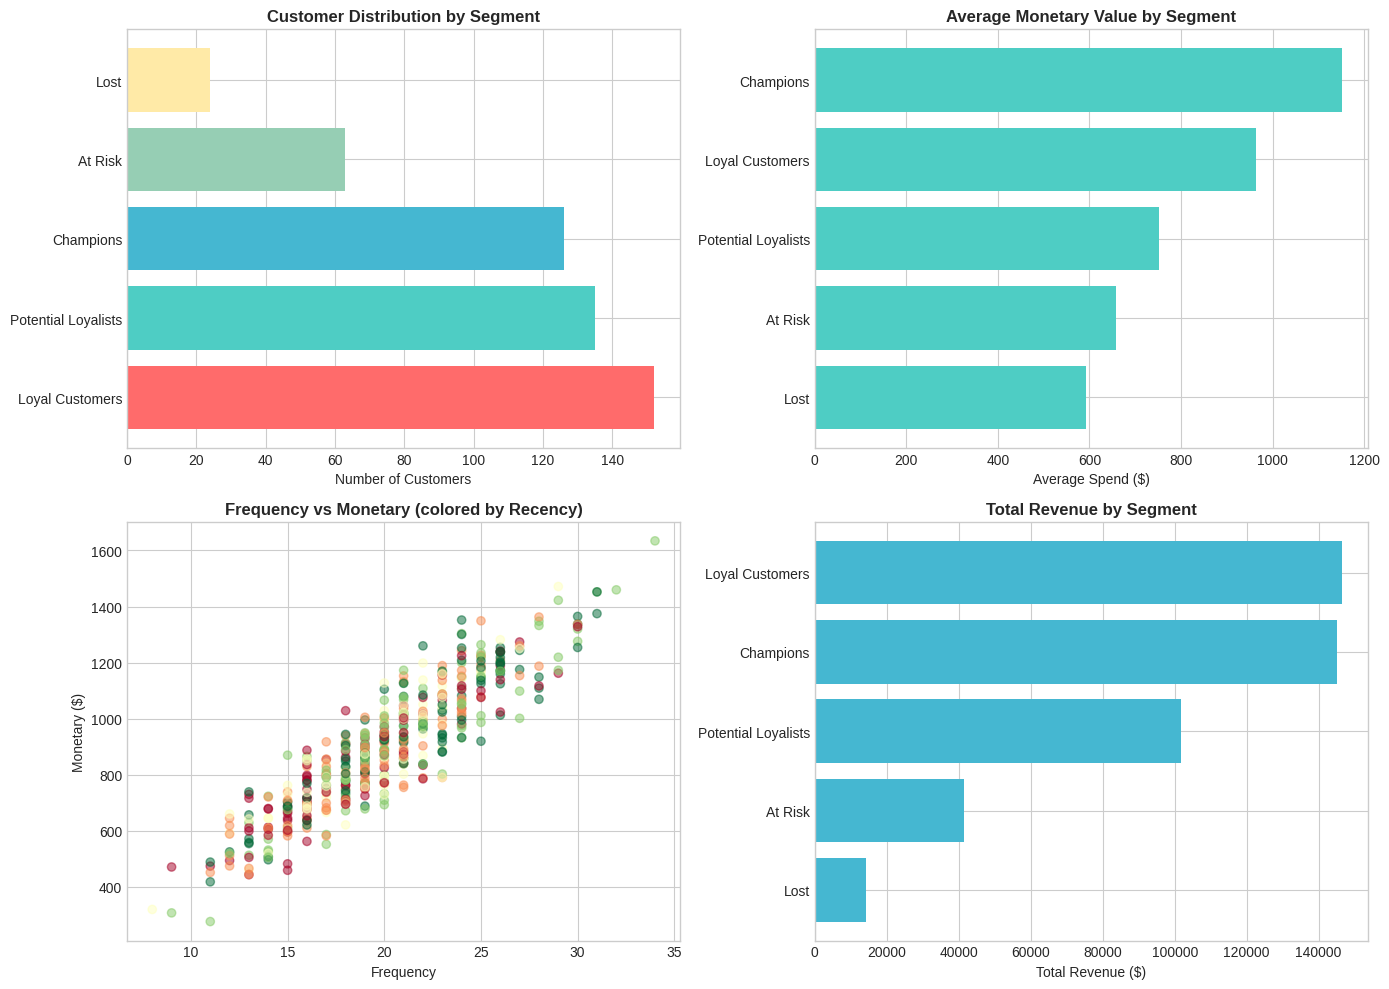

In [7]:
# Visualize RFM segments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Segment distribution
segment_counts = rfm_df["segment"].value_counts()
colors = [COLORS[i % len(COLORS)] for i in range(len(segment_counts))]
axes[0, 0].barh(segment_counts.index, segment_counts.values, color=colors)
axes[0, 0].set_title("Customer Distribution by Segment", fontweight="bold")
axes[0, 0].set_xlabel("Number of Customers")

# Monetary value by segment
segment_monetary = rfm_df.groupby("segment")["monetary"].mean().sort_values()
axes[0, 1].barh(segment_monetary.index, segment_monetary.values, color=COLORS[1])
axes[0, 1].set_title("Average Monetary Value by Segment", fontweight="bold")
axes[0, 1].set_xlabel("Average Spend ($)")

# RFM Score distribution
axes[1, 0].scatter(
    rfm_df["frequency"], rfm_df["monetary"], c=rfm_df["r_score"], cmap="RdYlGn", alpha=0.5
)
axes[1, 0].set_title("Frequency vs Monetary (colored by Recency)", fontweight="bold")
axes[1, 0].set_xlabel("Frequency")
axes[1, 0].set_ylabel("Monetary ($)")

# Revenue by segment
segment_revenue = rfm_df.groupby("segment")["monetary"].sum().sort_values()
axes[1, 1].barh(segment_revenue.index, segment_revenue.values, color=COLORS[2])
axes[1, 1].set_title("Total Revenue by Segment", fontweight="bold")
axes[1, 1].set_xlabel("Total Revenue ($)")

plt.tight_layout()
plt.show()

In [9]:
# Marketing recommendations by segment
recommendations = {
    'Champions': 'Reward with loyalty programs, exclusive offers. Ask for reviews.',
    'Loyal Customers': 'Upsell higher value products. Engage with personalized offers.',
    'Potential Loyalists': 'Offer membership/loyalty program. Recommend other products.',
    'At Risk': 'Send personalized reactivation campaigns. Offer special discounts.',
    'Lost': 'Win-back campaigns. Re-engage with strong offers.'
}

print("\nMarketing Recommendations by Segment:")
print("=" * 60)
for segment, rec in recommendations.items():
    count = len(rfm_df[rfm_df['segment'] == segment])
    print(f"\n{segment} ({count} customers):")
    print(f"  → {rec}")


Marketing Recommendations by Segment:

Champions (126 customers):
  → Reward with loyalty programs, exclusive offers. Ask for reviews.

Loyal Customers (152 customers):
  → Upsell higher value products. Engage with personalized offers.

Potential Loyalists (135 customers):
  → Offer membership/loyalty program. Recommend other products.

At Risk (63 customers):
  → Send personalized reactivation campaigns. Offer special discounts.

Lost (24 customers):
  → Win-back campaigns. Re-engage with strong offers.


## 2. Churn Prediction

Predict which customers are likely to churn (stop visiting) using machine learning.


In [11]:
# Churn Prediction (inline implementation)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Create churn labels based on recency
CHURN_THRESHOLD_DAYS = 60
rfm_df['is_churned'] = (rfm_df['recency'] > CHURN_THRESHOLD_DAYS).astype(int)

# Prepare features
X = rfm_df[['recency', 'frequency', 'monetary']]
y = rfm_df['is_churned']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
churn_model = RandomForestClassifier(n_estimators=100, random_state=42)
churn_model.fit(X_train, y_train)

# Evaluate
y_pred = churn_model.predict(X_test)
y_proba = churn_model.predict_proba(X_test)[:, 1]

print("Churn Prediction Model Trained!")
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

Churn Prediction Model Trained!

ROC-AUC Score: 1.000

Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00        97
     Churned       1.00      1.00      1.00         3

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



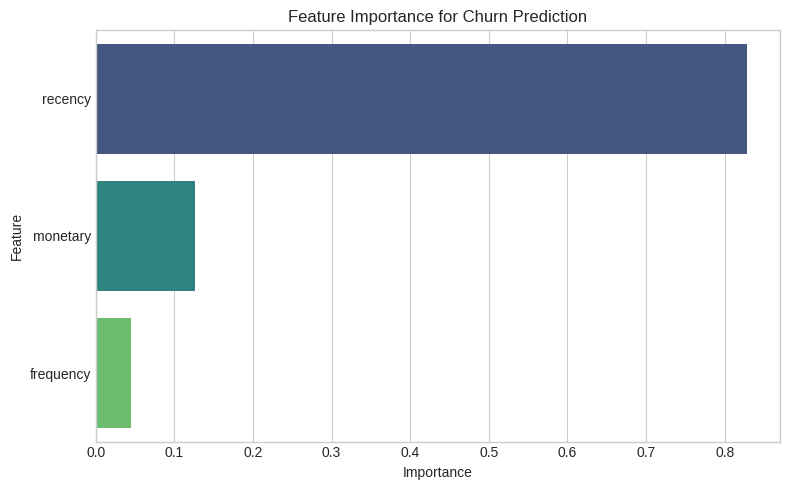


Top Features for Churn Prediction:
  feature  importance
  recency    0.828990
 monetary    0.126295
frequency    0.044715


In [13]:
# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': churn_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop Features for Churn Prediction:")
print(importance.to_string(index=False))

In [15]:
# Get at-risk customers
rfm_df['churn_probability'] = churn_model.predict_proba(X)[:, 1]
at_risk = rfm_df[rfm_df['churn_probability'] > 0.5].sort_values('churn_probability', ascending=False)

print(f"\nAt-Risk Customers (probability > 0.5): {len(at_risk)}")
print("\nTop 10 At-Risk Customers:")
at_risk[['customer_id', 'recency', 'frequency', 'monetary', 'churn_probability']].head(10)


At-Risk Customers (probability > 0.5): 14

Top 10 At-Risk Customers:


,customer_id,recency,frequency,monetary,churn_probability
328,329,115,16,677.55,0.98
140,141,72,16,749.16,0.96
393,394,123,16,654.05,0.94
152,153,78,17,750.43,0.92
302,303,66,16,693.87,0.91
202,203,70,18,764.06,0.88
94,95,90,16,798.09,0.87
95,96,88,11,474.45,0.86
276,277,68,21,1046.48,0.80
107,108,62,13,716.64,0.78


In [ ]:
# Churn probability distribution
all_predictions = churn_predictor.predict(features)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Probability distribution
axes[0].hist(all_predictions["churn_probability"], bins=50, color=COLORS[0], edgecolor="white")
axes[0].axvline(0.5, color="red", linestyle="--", label="Threshold (0.5)")
axes[0].set_title("Churn Probability Distribution", fontweight="bold")
axes[0].set_xlabel("Churn Probability")
axes[0].set_ylabel("Number of Customers")
axes[0].legend()

# Risk categories
risk_counts = all_predictions["churn_risk"].value_counts()
colors = ["green", "yellow", "orange", "red"]
axes[1].pie(risk_counts, labels=risk_counts.index, autopct="%1.1f%%", colors=colors)
axes[1].set_title("Customer Churn Risk Distribution", fontweight="bold")

plt.tight_layout()
plt.show()

## 3. K-Means Customer Segmentation

Use unsupervised learning to discover natural customer groups.


In [ ]:
from ml.pipelines.customer_analytics.customer_segmentation import CustomerSegmenter

# Initialize and fit segmenter (auto-determines optimal clusters)
segmenter = CustomerSegmenter(min_clusters=3, max_clusters=8)
segmenter.fit(transactions, customers)

print(f"\nOptimal number of clusters: {segmenter.n_clusters}")

In [ ]:
# Get segment profiles
profiles = segmenter.get_segment_profiles()

print("\nCustomer Segment Profiles:")
print("=" * 60)
profiles[
    [
        "cluster",
        "segment_name",
        "customer_count",
        "pct_of_customers",
        "avg_order_value",
        "avg_orders_per_month",
    ]
]

In [ ]:
# Segment summary with recommendations
summary = segmenter.get_segment_summary()

for segment in summary["segments"]:
    print(f"\n{segment['name']} (Cluster {segment['cluster']})")
    print(f"  Customers: {segment['customer_count']} ({segment['pct_of_customers']}%)")
    print(f"  Avg Order Value: ${segment['avg_order_value']:.2f}")
    print(f"  Description: {segment['description']}")
    print(f"  Strategy: {segment['strategy']}")

In [ ]:
# Visualize cluster centers
centers = segmenter.get_cluster_centers()

# Radar chart for cluster profiles
from math import pi

categories = [
    "recency_days",
    "total_transactions",
    "total_spent",
    "avg_order_value",
    "orders_per_month",
    "spend_per_month",
]

# Normalize for visualization
centers_norm = centers[categories].copy()
for col in categories:
    centers_norm[col] = (centers_norm[col] - centers_norm[col].min()) / (
        centers_norm[col].max() - centers_norm[col].min()
    )

fig, ax = plt.subplots(figsize=(10, 8))

for i, row in centers_norm.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the loop
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, "o-", linewidth=2, label=f'Cluster {int(centers.iloc[i]["cluster"])}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Cluster Profiles (Normalized)", fontweight="bold", size=14, y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

## 4. Customer Lifetime Value (LTV) Prediction

Predict the future value of each customer.


In [ ]:
from ml.pipelines.customer_analytics.customer_ltv import CustomerLTV

# Initialize and train LTV model
ltv_model = CustomerLTV(prediction_horizon_days=365)
metrics = ltv_model.train(transactions, customers)

print("\nLTV Prediction Model Metrics:")
print("=" * 40)
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

In [ ]:
# Feature importance for LTV
importance = ltv_model.feature_importance_

plt.figure(figsize=(10, 8))
top_features = importance.head(15)
plt.barh(top_features["feature"], top_features["importance"], color=COLORS[3])
plt.title("Top 15 Features for LTV Prediction", fontweight="bold")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Get LTV distribution
ltv_dist = ltv_model.get_ltv_distribution(transactions, customers)

print("\nLTV Distribution Statistics:")
print("=" * 40)
print(f"  Total Customers: {ltv_dist['count']:,}")
print(f"  Mean LTV: ${ltv_dist['mean']:.2f}")
print(f"  Median LTV: ${ltv_dist['median']:.2f}")
print(f"  Max LTV: ${ltv_dist['max']:.2f}")
print(f"  Total Predicted LTV: ${ltv_dist['total_predicted_ltv']:,.2f}")
print(f"\nPercentiles:")
for pct, value in ltv_dist["percentiles"].items():
    print(f"    {pct}th: ${value:.2f}")

In [ ]:
# High value customers
high_value = ltv_model.get_high_value_customers(transactions, customers, top_n=20)

print("\nTop 20 High-Value Customers:")
high_value

In [ ]:
# LTV visualization
predictions = ltv_model.predict_for_transactions(transactions, customers)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LTV distribution
axes[0].hist(predictions["predicted_ltv"], bins=50, color=COLORS[4], edgecolor="white")
axes[0].axvline(
    predictions["predicted_ltv"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: ${predictions['predicted_ltv'].mean():.2f}",
)
axes[0].set_title("Predicted LTV Distribution", fontweight="bold")
axes[0].set_xlabel("Predicted LTV ($)")
axes[0].set_ylabel("Number of Customers")
axes[0].legend()

# LTV segments
segment_counts = predictions["ltv_segment"].value_counts()
colors = [COLORS[i % len(COLORS)] for i in range(len(segment_counts))]
axes[1].pie(segment_counts, labels=segment_counts.index, autopct="%1.1f%%", colors=colors)
axes[1].set_title("Customer LTV Segments", fontweight="bold")

plt.tight_layout()
plt.show()

## 5. Combining Insights

Let's combine all customer analytics for a comprehensive view.


In [ ]:
# Combine all customer insights
customer_insights = rfm_df[["customer_id", "segment", "rfm_score"]].copy()
customer_insights = customer_insights.merge(
    all_predictions[["customer_id", "churn_probability", "churn_risk"]], on="customer_id"
)
customer_insights = customer_insights.merge(
    predictions[["customer_id", "predicted_ltv", "ltv_segment"]], on="customer_id"
)

print("\nCombined Customer Insights:")
print(f"Total customers with complete insights: {len(customer_insights):,}")
customer_insights.head(10)

In [ ]:
# Prioritize customers: High LTV + High Churn Risk
priority_customers = customer_insights[
    (customer_insights["ltv_segment"].isin(["High", "Above Average"]))
    & (customer_insights["churn_risk"].isin(["High", "Critical"]))
]

print(f"\n🚨 Priority Customers (High LTV + High Churn Risk): {len(priority_customers)}")
print("These customers need immediate retention efforts!")
priority_customers.head(10)

In [ ]:
# Save combined insights
from ml.utils.data_utils import DATA_DIR

customer_insights.to_csv(DATA_DIR / "customer_insights.csv", index=False)
print(f"\n[OK] Customer insights saved to {DATA_DIR / 'customer_insights.csv'}")